In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt

sns.set_style('white')

In [2]:
DATA = '../data/'

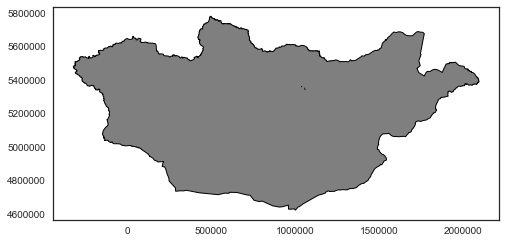

In [3]:
mongolia_map = gpd.read_file(DATA+'GIS/mongolia/mongolia_alagac_utm.shp')
mongolia_map.plot()

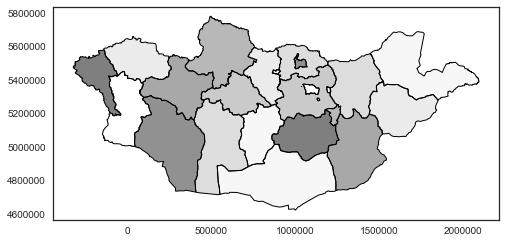

In [4]:
aimag_map = gpd.read_file(DATA+'GIS/aimag_boundaries/aimags_alagac_utm.shp').drop('NAME_L1', axis=1)
aimag_map.plot()

In [5]:
aimag_lookup = {'UB':'Ulaanbaatar',
            'DO':'Dornod',
            'SB':"Su'xbaatar", 
            'KhE':'Xentii',
            'TU':"To'v",
            'GS':"Govisu'mber", 
            'BG':'Dornogovi',
            'DA':'Darxan-Uul',
            'DU':'Dundgovi',
            'OR':'Orxon',
            'UV':"O'vorxangai", 
            'BU':'Bulgan',
            'BKh':'Bayanxongor',
            'AR':'Arxangai',
            'KhU':"Xo'vsgol",
            'ZA':'Zavxan',
            'GA':'Govi-Altai',
            'Bay':"Bayan-O'lgii", 
            'KhO':'Xovd',
            'UG':"O'mnogovi", 
            'UVs':'Uvs',
            'SE':'Selenge'}

In [6]:
aimag_map['Province'] = aimag_map.NAME.replace({aimag_lookup[code]:code for code in aimag_lookup})

Import line list

In [7]:
line_list = pd.read_csv(DATA+'clean/line_list.csv', parse_dates=['date_onset', 'dob', 'date_lab'])

In [8]:
lab_samples = line_list.dropna(subset=['date_lab']).copy()
lab_samples.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
8,20835.0,2015-11-25,UB,2015-09-01,0.238193,1.0,1.0,1.0,2015-12-01,0.0,True,11.0,2015.0
9,21053.0,2015-12-02,UB,2014-11-19,1.062286,0.0,1.0,1.0,2015-12-14,0.0,False,12.0,2015.0


In [9]:
pd.crosstab(lab_samples.confirmed, lab_samples.labconfirmed)

labconfirmed,0.0,1.0
confirmed,,
0.0,1218,0
1.0,1855,4015


In [10]:
aimag_map.head()

,AREA_M2,ID,LENGTH_M,NAME,OBJECTID,PARENT_ID,SHAPE_AREA,SHAPE_LEN,TYPE,UNIT_STATU,geometry,Province
0,4.735383e+09,11,4.786412e+05,Ulaanbaatar,2,1,4736.028353,5.405426,2,1,(POLYGON ((1064208.858495513 5370725.455944032...,UB
1,1.235185e+11,21,2.208690e+06,Dornod,3,1,123527.196907,25.333832,2,1,"POLYGON ((1540617.076159357 5638446.384644163,...",DO
2,8.235105e+10,22,1.323859e+06,Su'xbaatar,4,1,82323.874121,14.860285,2,1,"POLYGON ((1526003.850553003 5389374.5959672, 1...",SB
3,8.069372e+10,23,1.472892e+06,Xentii,5,1,80745.839694,16.285330,2,1,"POLYGON ((1448514.971882628 5552536.507390657,...",KhE
4,7.396939e+10,41,2.046344e+06,To'v,6,1,73988.555729,23.471340,2,1,"POLYGON ((1193224.564212453 5488464.533822741,...",TU


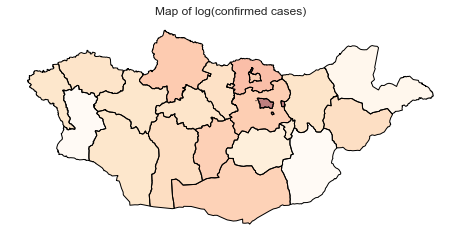

In [11]:
ax = (aimag_map.join(lab_samples.assign(NAME=lab_samples.provincecity.replace(aimag_lookup))
                 .groupby('NAME')
                 .labconfirmed.sum().apply(np.log), on='NAME')
             .plot(column='labconfirmed', cmap='OrRd'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_title('Map of log(confirmed cases)');

In [12]:
lab_samples['onset_to_lab'] = (lab_samples.date_lab - lab_samples.date_onset).dt.days

In [13]:
(lab_samples.onset_to_lab<0).sum()

33

In [14]:
lab_samples.loc[lab_samples.onset_to_lab<0, 'onset_to_lab'] = np.nan

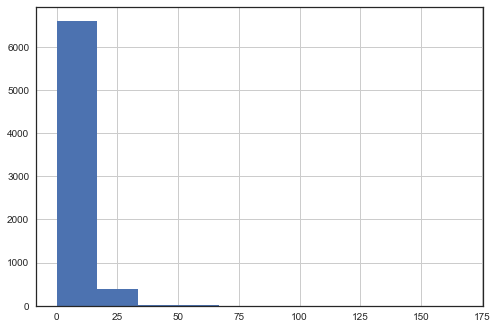

In [15]:
lab_samples.onset_to_lab.hist()

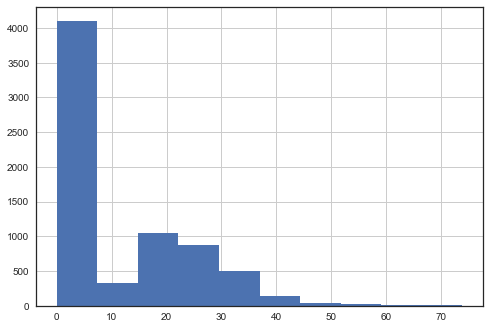

In [16]:
lab_samples.age_years.hist()

Extract clinic-confirmed cases

In [17]:
clinic_confirmed = lab_samples.query('confirmed==1')

In [18]:
clinic_confirmed.isnull().sum()

id                 0
date_onset        29
provincecity       2
dob               22
age_years         24
died               0
confirmed          0
labconfirmed       0
date_lab           0
vaccine_ever    1797
male               0
month_onset       29
year_onset        29
onset_to_lab      56
dtype: int64

### Reporting lag model

In [19]:
from pymc3 import sample, Model, invlogit, DataSampler, fit, generator
from pymc3 import Deterministic, SVGD, GaussianRandomWalk
from pymc3.gp import cov, sample_gp
from pymc3 import MvNormal, Normal, Bernoulli, Gamma, HalfCauchy, Uniform, Flat, Binomial
from pymc3 import traceplot, forestplot, summary, generator, energyplot
from pymc3.math import invprobit

import theano.tensor as tt
from theano import shared

In [51]:
lag, confirmed = clinic_confirmed.dropna(subset=['onset_to_lab'])[['onset_to_lab', 'labconfirmed']].values.T

In [52]:
batch_size=50

def create_minibatch(data):
    rng = np.random.RandomState(20090425)
    
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=batch_size)
        yield data[ixs]

In [53]:
lag_batch = generator(create_minibatch(lag.reshape(-1,1)))
confirmed_batch = generator(create_minibatch(confirmed))

with Model() as lag_model:
    
    ρ = Gamma('ρ', 1, 1)
    η = HalfCauchy('η', 1)
    σ = HalfCauchy('σ', 1)
    b = 1e-6
    
    K = b + η * cov.ExpQuad(1, ρ)
    
    y = MvNormal('y', tt.zeros(batch_size), K(lag_batch) + tt.eye(batch_size)*σ, 
                 shape=batch_size)
    
    π = invlogit(y)

    confirmation = Bernoulli('confirmation', p=π, observed=confirmed_batch)

In [54]:
with lag_model:

    # Prediction over grid
    xgrid = np.linspace(lag.min(), lag.max(), num=12)
    
    y_pred = MvNormal('y_pred', np.zeros(12), K(xgrid.reshape(-1,1)), shape=12)

In [55]:
with lag_model:
    lag_trace = fit(method='advi', n=10000).sample(1000)

Average Loss = 42.698: 100%|██████████| 10000/10000 [00:16<00:00, 596.06it/s]
Finished [100%]: Average Loss = 42.699


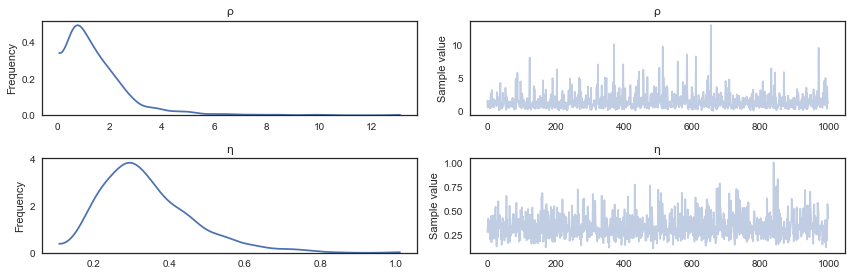

In [56]:
traceplot(lag_trace, varnames=['ρ', 'η']);

In [57]:
expit = lambda x: 1/(1 + np.exp(-x))

In [58]:
lag_data = pd.DataFrame({'lag': lag,
                        'obs': confirmed})

In [59]:
y_pred = lag_trace['y_pred', -100:].T

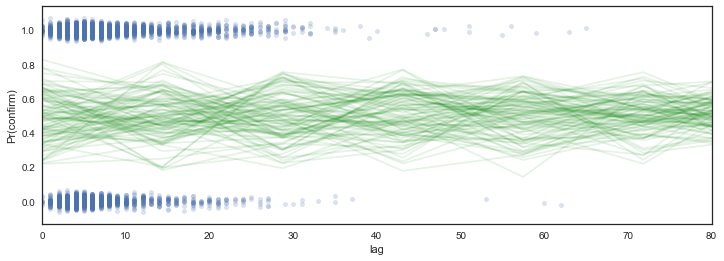

In [60]:
ax = (lag_data.assign(obsj=lag_data.obs+0.02*np.random.randn(len(lag_data)))
              .plot.scatter(x='lag', y='obsj', alpha=0.2, figsize=(12,4)))
plt.plot(xgrid, expit(y_pred), 'g-', alpha=0.1)
ax.set_xlim(0,80)
ax.set_ylabel('Pr(confirm)');

### Age model

In [35]:
confirmed, age = clinic_confirmed.dropna(subset=['age_years'])[['labconfirmed', 'age_years']].values.T

In [43]:
age_batch = generator(create_minibatch(age.reshape(-1,1)))
confirmed_batch = generator(create_minibatch(confirmed))

with Model() as age_model:
    
    ρ = Gamma('ρ', 1, 1)
    η = HalfCauchy('η', 1)
    σ = HalfCauchy('σ', 1)
    b = 1e-6
    
    K = b + η * cov.Matern32(1, ρ)
    
    y = MvNormal('y', tt.zeros(batch_size), K(age_batch) + tt.eye(batch_size)*σ, 
                 shape=batch_size)
    
    π = invlogit(y)

    confirmation = Bernoulli('confirmation', p=π, observed=confirmed_batch)

In [44]:
with age_model:

    # Prediction over grid
    xgrid = np.linspace(age.min(), age.max(), num=12)
    
    y_pred = MvNormal('y_pred', np.zeros(12), K(xgrid.reshape(-1,1)), shape=12)

In [45]:
with age_model:
    trace_age = fit(n=50000).sample(1000) #sample(2000, n_init=50000, tune=1000, njobs=2)

Average Loss = 42.357: 100%|██████████| 50000/50000 [01:28<00:00, 566.82it/s]
Finished [100%]: Average Loss = 42.364


In [46]:
predictions = pd.DataFrame({'age': age,
                            'obs': confirmed})

In [47]:
y_pred = trace_age['y_pred', -100:].T

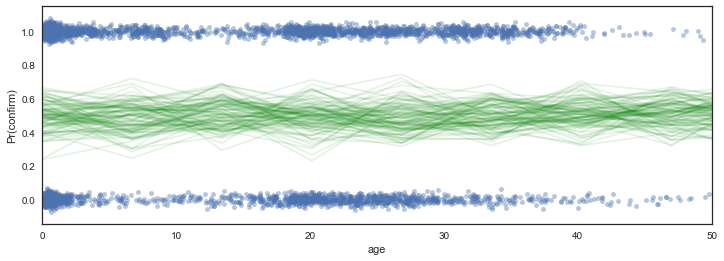

In [50]:
ax = (predictions.assign(obsj=predictions.obs+0.02*np.random.randn(len(predictions)))
              .plot.scatter(x='age', y='obsj', alpha=0.4, figsize=(12,4)))
plt.plot(xgrid, expit(y_pred), 'g-', alpha=0.1)
ax.set_xlim(0,50)
ax.set_ylabel('Pr(confirm)');

## Combined model